In [2]:
#test the geo distance matrix, added in the function files
#weighted cluster method
library('data.table')
library('ggplot2')
library('ggmap')
library('dbscan')
library('dplyr')
library('xts')
funPath='D:/Git/Rprojects/ECA/function.R'
source(funPath)

In [6]:
dataPath='C:/Users/wzh/Desktop/compressed_trajectory_215896000.csv'
dataPath2='D:/Git/data/container/215896000.txt'
dataPath3='D:/Git/data/ECAContainerSpeedLessThanOneKnot/3438807_3.csv'
#dt=fread(file=dataPath);setnames(dt,c('mmsi','time','sog','lon','lat','status'));head(dt)
#dt=fread(file=dataPath);setnames(dt,c('mmsi','time','sog','lon','lat'));head(dt)
dt0=fread(file=dataPath2);setnames(dt0,c('mmsi','time','sog','lon','lat','status'))
dt0=dt0[,list(mmsi,time,sog,lon,lat,status)];head(dt0)

mmsi      time       sog lon     lat      status
1 215896000 1325059016 0   23.5885 37.95616 0     
2 215896000 1325059137 0   23.5885 37.95616 0     
3 215896000 1325059146 0   23.5885 37.95616 0     
4 215896000 1325059217 0   23.5885 37.95616 0     
5 215896000 1325059260 0   23.5885 37.95616 0     
6 215896000 1325059268 0   23.5885 37.95616 0

In [8]:
setkey(dt0,mmsi,time)
dt=dt0[sog==0];nrow(dt0)
set.seed(1234)
#sampledt0=sample_n(dt,200000)
sampledt=dt[status==5];nrow(sampledt)

[1] 124580

[1] 17730

In [9]:
tmp=dt[status==5];key(tmp)
tmp=tmp[,atime:=align.time(as.POSIXct(time,origin='1970-01-01'),60*20)];dim(tmp);head(tmp);nrow(tmp[,.N,list(mmsi,atime)])
sampledt=tmp[,.SD[1],list(mmsi,atime)];dim(sampledt);head(sampledt)

[1] "mmsi" "time"

[1] 17730     7

mmsi      time       sog lon     lat      status atime              
1 215896000 1325462171 0   29.0075 41.00600 5      2012-01-01 16:00:00
2 215896000 1325468650 0   29.0075 41.00600 5      2012-01-01 18:00:00
3 215896000 1325470451 0   29.0075 41.00600 5      2012-01-01 18:20:00
4 215896000 1325470812 0   29.0075 41.00617 5      2012-01-01 18:40:00
5 215896000 1325471530 0   29.0075 41.00600 5      2012-01-01 18:40:00
6 215896000 1325471891 0   29.0075 41.00600 5      2012-01-01 18:40:00

[1] 4322

[1] 4322    7

mmsi      atime               time       sog lon     lat      status
1 215896000 2012-01-01 16:00:00 1325462171 0   29.0075 41.00600 5     
2 215896000 2012-01-01 18:00:00 1325468650 0   29.0075 41.00600 5     
3 215896000 2012-01-01 18:20:00 1325470451 0   29.0075 41.00600 5     
4 215896000 2012-01-01 18:40:00 1325470812 0   29.0075 41.00617 5     
5 215896000 2012-01-01 19:00:00 1325472249 0   29.0075 41.00600 5     
6 215896000 2012-01-01 20:40:00 1325478727 0   29.0075 41.00617 5

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=41.752582,20.629416&zoom=5&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


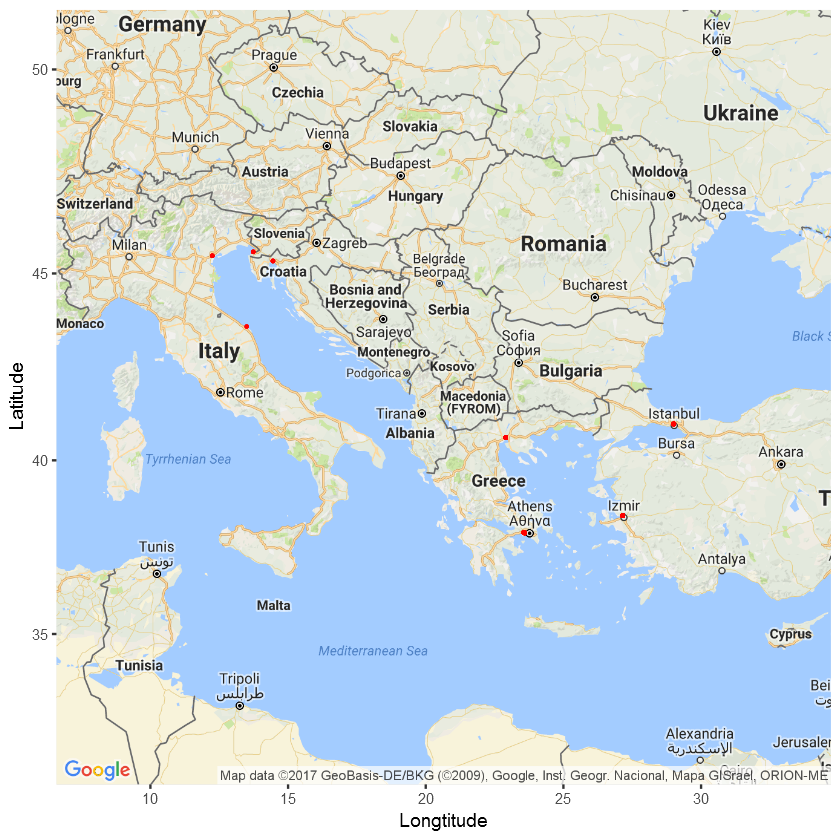

In [13]:
zoomSize=5
temp=sampledt
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'roadmap'))
#p=p+geom_path(data=temp,aes(x=lon,y=lat),color='green',size=0.1)
p=p+geom_point(data=temp,aes(x=lon,y=lat),color='red',size=0.2,alpha=0.75)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.9,0.2))
p

In [46]:
e=0.004
distance(40,25,40+e,25+e)
dt1 <- as.matrix(sampledt[,list(lon,lat)])
#kNNdistplot(dt1, k=10)
## the knee is around a distance of .4
cl <- dbscan(dt1, eps = 0.004, minPts =3,borderPoints=FALSE)
dt2=data.table(cbind(sampledt,c=cl$cluster));
nrow(dt2[c>0,.N,c])

[1] 600.9384

[1] 10

In [37]:
#head(dt2)
cships=dt2[,.N,by=list(c,mmsi)][,mmsi,c][,.N,c]
#cships

[1] 4322

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=41.752582,20.629416&zoom=5&size=640x640&scale=2&maptype=satellite&language=en-EN&sensor=false


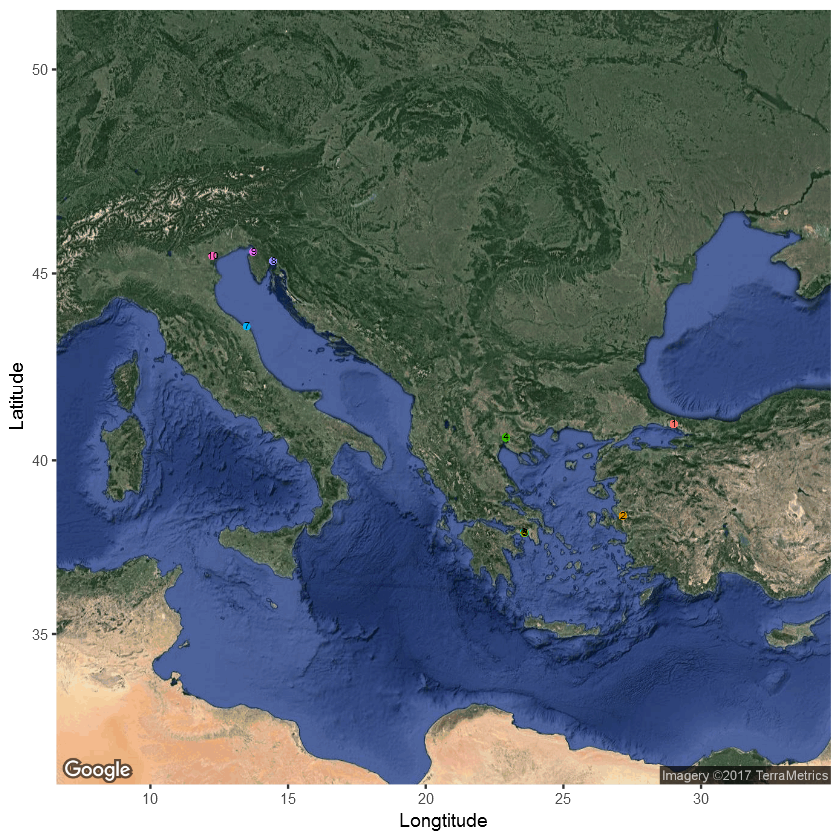

In [38]:
zoomSize=5
temp=dt2[c>0];nrow(temp)
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))
p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(c)),size=1,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],c],nudge_x = 0.02,nudge_y = 0.02,aes(x=lon,y=lat,label=c),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position="none")
p

#### as shown from above figure, we can see that the shape of a terminal or a group of berths are a narrow rectangle.This feature may be able to be used to remove clusters which are not really a berth such archor area

[1] 4

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=43.62225,13.4975&zoom=17&size=640x640&scale=2&maptype=satellite&language=en-EN&sensor=false
Warning message:
"Removed 1 rows containing missing values (geom_text)."

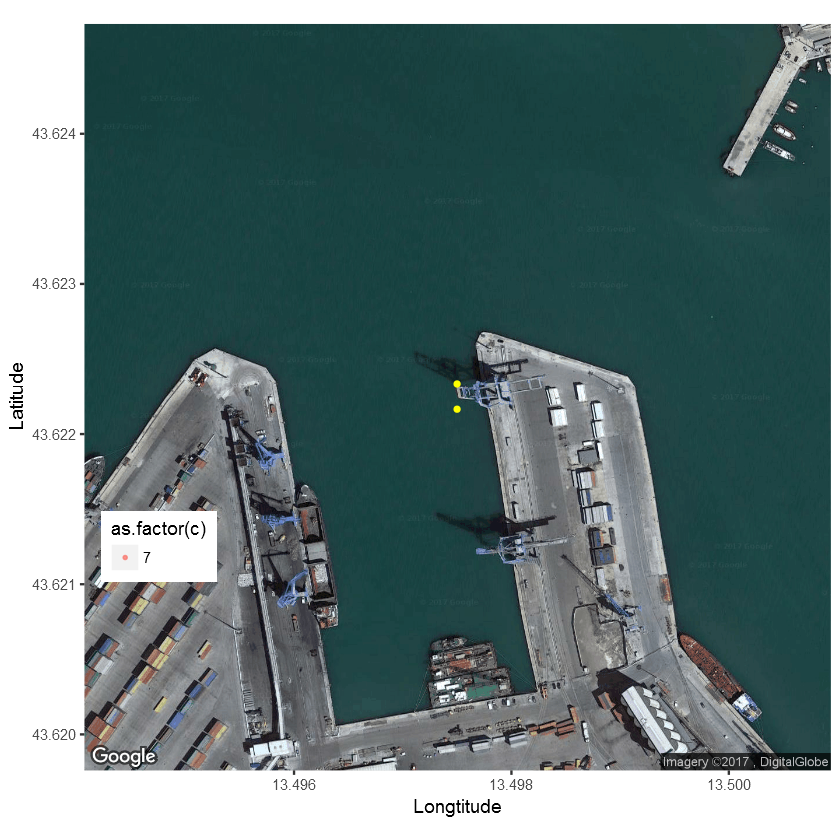

In [47]:
zoomSize=17
temp=dt2[c==7];nrow(temp)
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))
p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(c)),size=0.5,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],c],nudge_x = 0.05,nudge_y = 0.05,aes(x=lon,y=lat,label=c),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.1,0.3))
#p
hulls=temp[chull(temp[,list(lon,lat)]),]
p=p+geom_point(data = hulls, aes(x = lon, y = lat),size=1,col='yellow') 
p=p+geom_polygon(data = hulls, aes(x = lon, y = lat),fill='yellow',alpha = 0.4)
p


[1] 27054

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=30.619974,122.065181&zoom=14&size=640x640&scale=2&maptype=satellite&language=en-EN&sensor=false
Warning message:
"Removed 1 rows containing missing values (geom_text)."

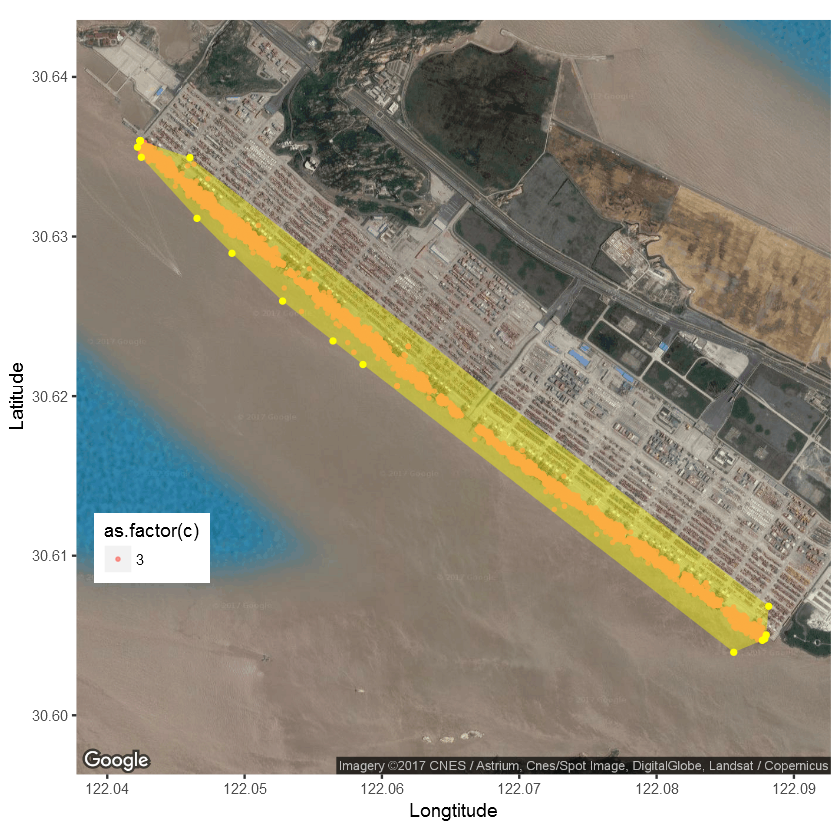

In [154]:
zoomSize=14
temp=dt2[c==3];nrow(temp)

centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))

p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(c)),size=0.5,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],c],nudge_x = 0.05,nudge_y = 0.05,aes(x=lon,y=lat,label=c),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.1,0.3))
#p
hulls=temp[chull(temp[,list(lon,lat)]),]
p=p+geom_point(data = hulls, aes(x = lon, y = lat),size=1,col='yellow') 
p=p+geom_polygon(data = hulls, aes(x = lon, y = lat),fill='yellow',alpha = 0.4)
p

[1] 50

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=30.194034,122.059124&zoom=14&size=640x640&scale=2&maptype=satellite&language=en-EN&sensor=false
Warning message:
"Removed 1 rows containing missing values (geom_text)."

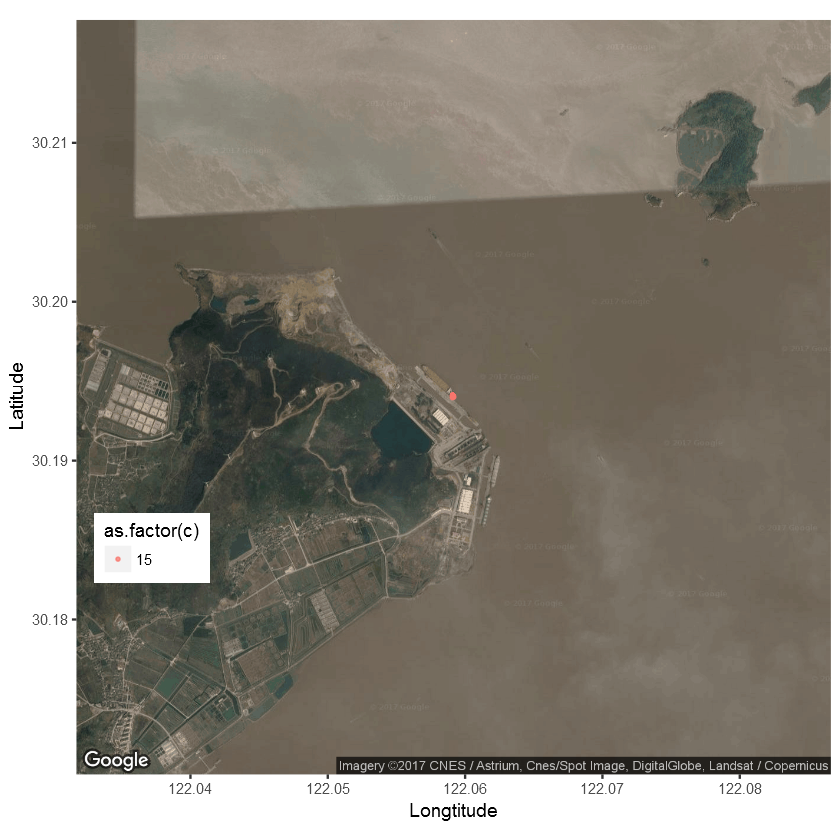

In [144]:
zoomSize=14
temp=dt2[c==15];nrow(temp)

centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))

p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(c)),size=0.5,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],c],nudge_x = 0.05,nudge_y = 0.05,aes(x=lon,y=lat,label=c),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.1,0.3))
p

[1] 22320

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=31.373266,121.583489&zoom=16&size=640x640&scale=2&maptype=satellite&language=en-EN&sensor=false
Warning message:
"Removed 9761 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing missing values (geom_text)."

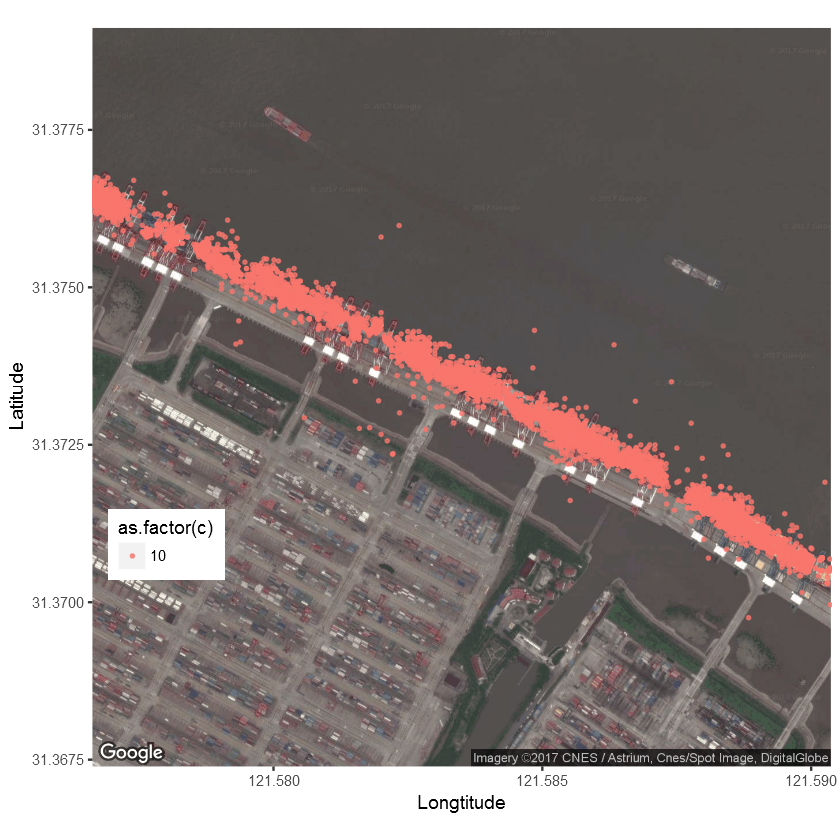

In [145]:
zoomSize=16
temp=dt2[c==10];nrow(temp)

centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))

p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(c)),size=0.5,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],c],nudge_x = 0.05,nudge_y = 0.05,aes(x=lon,y=lat,label=c),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.1,0.3))
p

[1] 2500

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=29.988231,121.838485&zoom=16&size=640x640&scale=2&maptype=satellite&language=en-EN&sensor=false
Warning message:
"Removed 1 rows containing missing values (geom_text)."

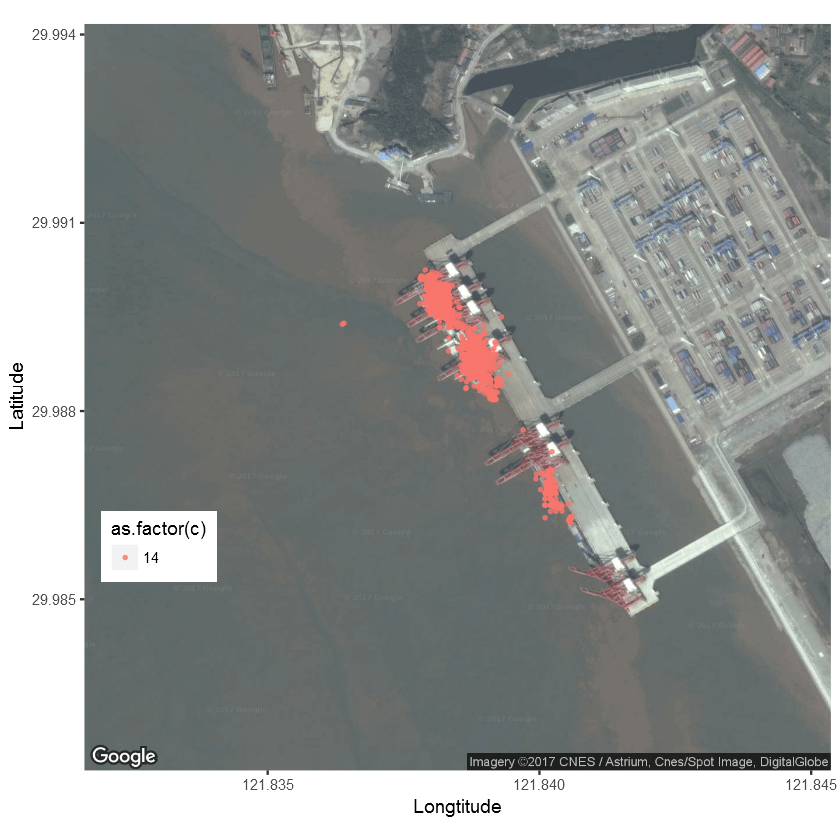

In [146]:
zoomSize=16
temp=dt2[c==14];nrow(temp)

centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))

p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(c)),size=0.5,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],c],nudge_x = 0.05,nudge_y = 0.05,aes(x=lon,y=lat,label=c),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.1,0.3))
p

In [147]:
#calcuate duration of each trip for each ship in each cluster
dt3=dt2[c>0,.N,list(c,mmsi)]
#head(dt2)
setkey(dt3,c,mmsi)
#head(dt3);dim(dt3)

In [148]:
eps.time=3600*2
minp=5
nr=nrow(dt3)
#nr=14
t0=data.table(mmsi=0,c=0,c1=0,dur=0)[mmsi<0]
for (i in seq(1:nr)){
    r=dt3[i]
    
    cship=dt2[mmsi==r$mmsi&c==r$c]
    setkey(cship,mmsi,time)
    cship2 <- as.matrix(cship[,time:=(time-min(cship$time))][,list(time)])#get time series
    cl2 <- dbscan(cship2, eps = eps.time, minPts =minp)
    cship3=data.table(cbind(cship,c1=cl2$cluster));
    if(nrow(cship3[c1>0])>0){
        
        t1=cship3[c1>0,list(dur=(max(.SD$time)-min(.SD$time))/3600),by=list(c,mmsi,c1)]
        t0=rbind(t0,t1) 
    }
}



In [151]:
#head(t0)
t2=t0[,list(uniques=length(unique(.SD$mmsi)),mean=mean(dur),median=median(dur)),c]
t3=t0[,list(uniques=length(unique(.SD$mmsi)),mean=mean(dur),median=median(dur)),c][mean<20]
t4=t0[,list(uniques=length(unique(.SD$mmsi)),mean=mean(dur),median=median(dur)),c][mean<20][uniques>5]
t2
t3
t4

c   uniques mean       median    
1    1  146      11.140976  10.922222
2    2   94       9.528359   9.345556
3    3  286      12.820992  12.249167
4    4   74       9.868813   9.000556
5    5  136      11.949152  11.054583
6    6   95      11.037333   9.895833
7    7   64       9.725343   8.783194
8    8    4      61.052747  46.664167
9    9    7      53.485139  20.697222
10  10  131      12.941402  12.038750
11  11    1      17.424722  19.258056
12  12    5      27.364699   8.300139
13  13    1       4.202083   4.202083
14  14   54       8.966437   9.076667
15  15    1      17.282500  17.282500
16  16    2      24.834111  24.053056
17  17    4      51.650025  21.194167
18  18    1     160.535278 160.535278
19  19    1       3.022500   3.022500
20  21    1      90.863333  90.863333
21  22    2      65.388512  27.015139
22  23    4      53.123364  48.369444
23  24    6      31.536431   7.900833
24  25    8      23.678420  10.900278
25  26    1       1.650000   1.650000
26  27    5      20.003492   8.901389
27  28    8      56.821644   7.300556
28  29    1       1.686111   1.686111
29  30    4      74.000667  51.851389
30  31    2      17.383704   7.200000
... ... ...     ...        ...       
36  37   1       68.552778  68.552778
37  38   2       38.254599  37.120556
38  39   1        3.960972   3.960972
39  41   1       21.442222  21.442222
40  42   1       20.652778  20.652778
41  43   1        8.892292   7.000417
42  44   1       21.620556  21.620556
43  45   3       75.791111  80.848750
44  46   1        3.801528   3.801528
45  47  17      100.481370  41.218333
46  48   4       41.114556  24.310000
47  49   1        3.001389   3.001389
48  50   1        3.451111   3.451111
49  51   3       10.326296   6.228056
50  52   1      135.581389 135.581389
51  53   1       27.685486  12.130556
52  54   1       32.872269  19.589722
53  55   1      132.080000 132.080000
54  56   2       70.793632   6.400278
55  58   1        2.650000   2.650000
56  59   1        4.300648   4.598333
57  60   3       75.949056  12.250556
58  61   2      164.230417 164.230417
59  62   3       79.986500  18.501111
60  63   1       31.753889  31.753889
61  65   1        2.699722   2.699722
62  67   1       72.635556  72.635556
63  68   1       35.609028  35.609028
64  69   2       28.406722  13.960556
65  70   1       21.586944  21.586944

c  uniques mean      median   
1   1 146     11.140976 10.922222
2   2  94      9.528359  9.345556
3   3 286     12.820992 12.249167
4   4  74      9.868813  9.000556
5   5 136     11.949152 11.054583
6   6  95     11.037333  9.895833
7   7  64      9.725343  8.783194
8  10 131     12.941402 12.038750
9  11   1     17.424722 19.258056
10 13   1      4.202083  4.202083
11 14  54      8.966437  9.076667
12 15   1     17.282500 17.282500
13 19   1      3.022500  3.022500
14 26   1      1.650000  1.650000
15 29   1      1.686111  1.686111
16 31   2     17.383704  7.200000
17 33   1      3.220000  3.220000
18 34   2      3.737037  3.270278
19 35   1      9.915278  9.915278
20 36   1      7.967778  7.967778
21 39   1      3.960972  3.960972
22 43   1      8.892292  7.000417
23 46   1      3.801528  3.801528
24 49   1      3.001389  3.001389
25 50   1      3.451111  3.451111
26 51   3     10.326296  6.228056
27 58   1      2.650000  2.650000
28 59   1      4.300648  4.598333
29 65   1      2.699722  2.699722

c  uniques mean      median   
1  1 146     11.140976 10.922222
2  2  94      9.528359  9.345556
3  3 286     12.820992 12.249167
4  4  74      9.868813  9.000556
5  5 136     11.949152 11.054583
6  6  95     11.037333  9.895833
7  7  64      9.725343  8.783194
8 10 131     12.941402 12.038750
9 14  54      8.966437  9.076667

[1] 118596

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=30.572221,121.829788&zoom=8&size=640x640&scale=2&maptype=satellite&language=en-EN&sensor=false


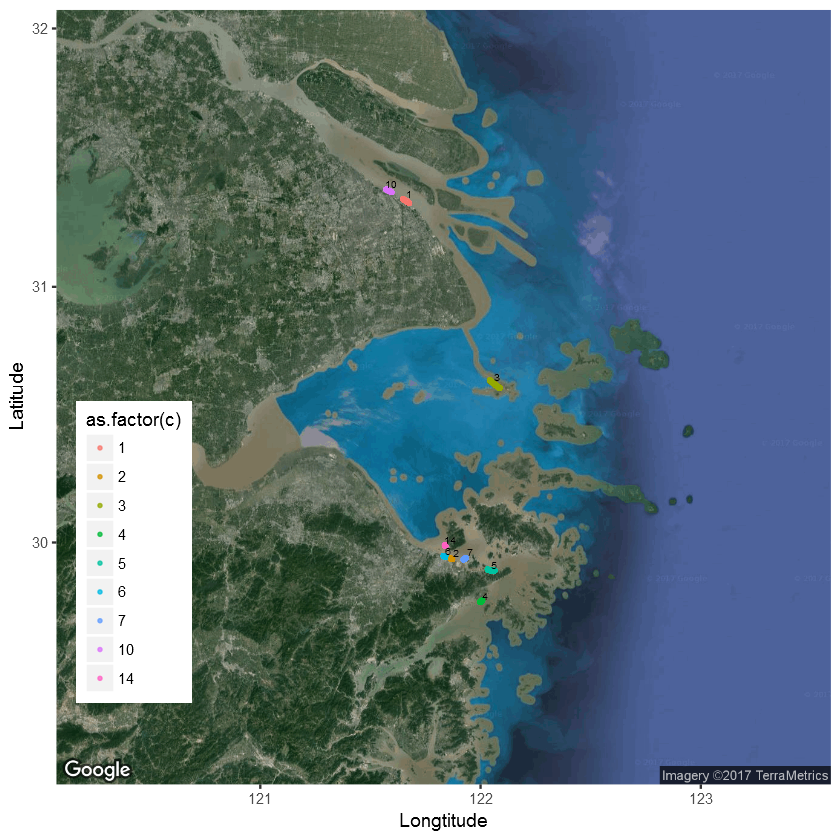

In [152]:
tms=t4$c
zoomSize=8
temp=dt2[c>0&c%in%tms];nrow(temp)
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'satellite'))

p=p+geom_point(data=temp,aes(x=lon,y=lat,col=as.factor(c)),size=0.5,alpha=0.75)
p=p+geom_text(data=temp[,.SD[1],c],nudge_x = 0.02,nudge_y = 0.02,aes(x=lon,y=lat,label=c),color='black',size=2)
p=p+labs(x="Longtitude",y="Latitude")+theme(legend.position=c(0.1,0.3))
p